<a href="https://colab.research.google.com/github/vincenzobucciero/mySegmentAnything/blob/main/maskGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!nvidia-smi

Thu Mar  7 12:01:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              32W /  70W |   6405MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [19]:
#install segment anything model
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [20]:
# download SAM WEIGHTS
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [21]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

In [22]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [23]:
# download example data
!mkdir -p {HOME}/data/imageTest
!mkdir -p {HOME}/data/videoTest
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data/imageTest
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data/imageTest
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data/imageTest
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data/imageTest

In [24]:
# load model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [25]:
# automated mask generator
# To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class. Set the path below to the SAM checkpoint
mask_generator = SamAutomaticMaskGenerator(sam)

import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data/imageTest", IMAGE_NAME)

# VIDEO_NAME = "videoSample1.mp4"
# VIDEO_PATH = os.path.join(HOME, "data/videoTest", VIDEO_NAME)

import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)


In [26]:
# output format
# SamAutomaticMaskGenerator returns a list of masks, where each mask is a dict containing various information about the mask:

#   segmentation - [np.ndarray] - the mask with (W, H) shape, and bool type
#   area - [int] - the area of the mask in pixels
#   bbox - [List[int]] - the boundary box of the mask in xywh format
#   predicted_iou - [float] - the model's own prediction for the quality of the mask
#   point_coords - [List[List[float]]] - the sampled input point that generated this mask
#   stability_score - [float] - an additional measure of mask quality
#   crop_box - List[int] - the crop of the image used to generate this mask in xywh format

print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


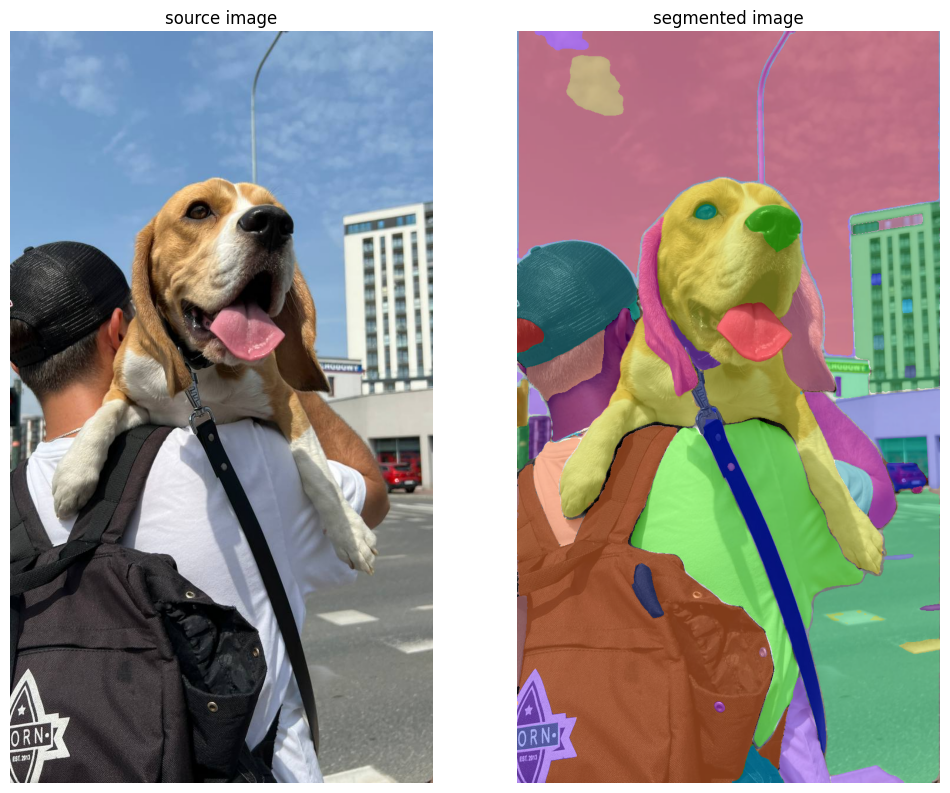

[[False False False ...  True False False]
 [False False False ...  True False False]
 [False False False ...  True False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
ENCODING RLE -> example 1 mask
[3, 451, 20, 244, 5, 451, 20, 244, 5, 451, 20, 244, 5, 450, 20, 245, 5, 450, 17, 248, 5, 449, 15, 251, 5, 449, 13, 253, 5, 448, 13, 254, 5, 448, 12, 255, 5, 447, 13, 255, 5, 446, 13, 256, 5, 446, 13, 256, 5, 445, 13, 257, 5, 445, 13, 257, 5, 444, 13, 258, 5, 443, 13, 259, 5, 443, 13, 259, 5, 442, 13, 260, 5, 442, 12, 261, 5, 441, 13, 261, 5, 440, 13, 262, 5, 440, 13, 262, 5, 440, 12, 263, 5, 439, 13, 263, 5, 438, 13, 264, 5, 438, 13, 264, 5, 437, 13, 265, 5, 436, 14, 265, 5, 435, 14, 266, 5, 434, 14, 267, 5, 434, 14, 267, 5, 433, 14, 268, 5, 433, 13, 269, 5, 432, 14, 269, 5, 432, 13, 270, 5, 431, 14, 270, 5, 431, 13, 271, 5, 430, 13, 272, 5, 429, 13, 273, 5, 429, 12, 274, 5, 428, 12, 275, 5, 427,

In [27]:
mask_id_counter = 1

# Results visualisation with Supervision

import matplotlib.pyplot as plt
import numpy as np

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# print segmentation
print(sam_result[0]['segmentation'])


# rle encoding
from itertools import groupby

def mask_to_rle(m, maxstride=100000000):
    # reshape mask to vector
    v = m.reshape((m.shape[0] * m.shape[1]))

    if v.size == 0:
        return [0]

    # output is empty at the beginning
    rle = []
    # index of the last different element
    last_idx = 0
    # check if first element is 1, so first element in RLE (number of zeros) must be set to 0
    if v[0] > 0:
        rle.append(0)

    # go over all elements and check if two consecutive are the same
    for i in range(1, v.size):
        if v[i] != v[i - 1]:
            length = i - last_idx
            # if length is larger than maxstride, split it into multiple elements
            while length > maxstride:
                rle.append(maxstride)
                rle.append(0)
                length -= maxstride
            # add remaining length
            if length > 0:
                rle.append(length)
            last_idx = i

    if v.size > 0:
        # handle last element of rle
        if last_idx < v.size - 1:
            # last element is the same as one element before it - add number of these last elements
            length = v.size - last_idx
            while length > maxstride:
                rle.append(maxstride)
                rle.append(0)
                length -= maxstride
            if length > 0:
                rle.append(length)
        else:
            # last element is different than one element before - add 1
            rle.append(1)
    return rle
print("ENCODING RLE -> example 1 mask")
print(mask_to_rle(sam_result[0]['segmentation']))
print("Numero di maschere trovate:", len(sam_result))

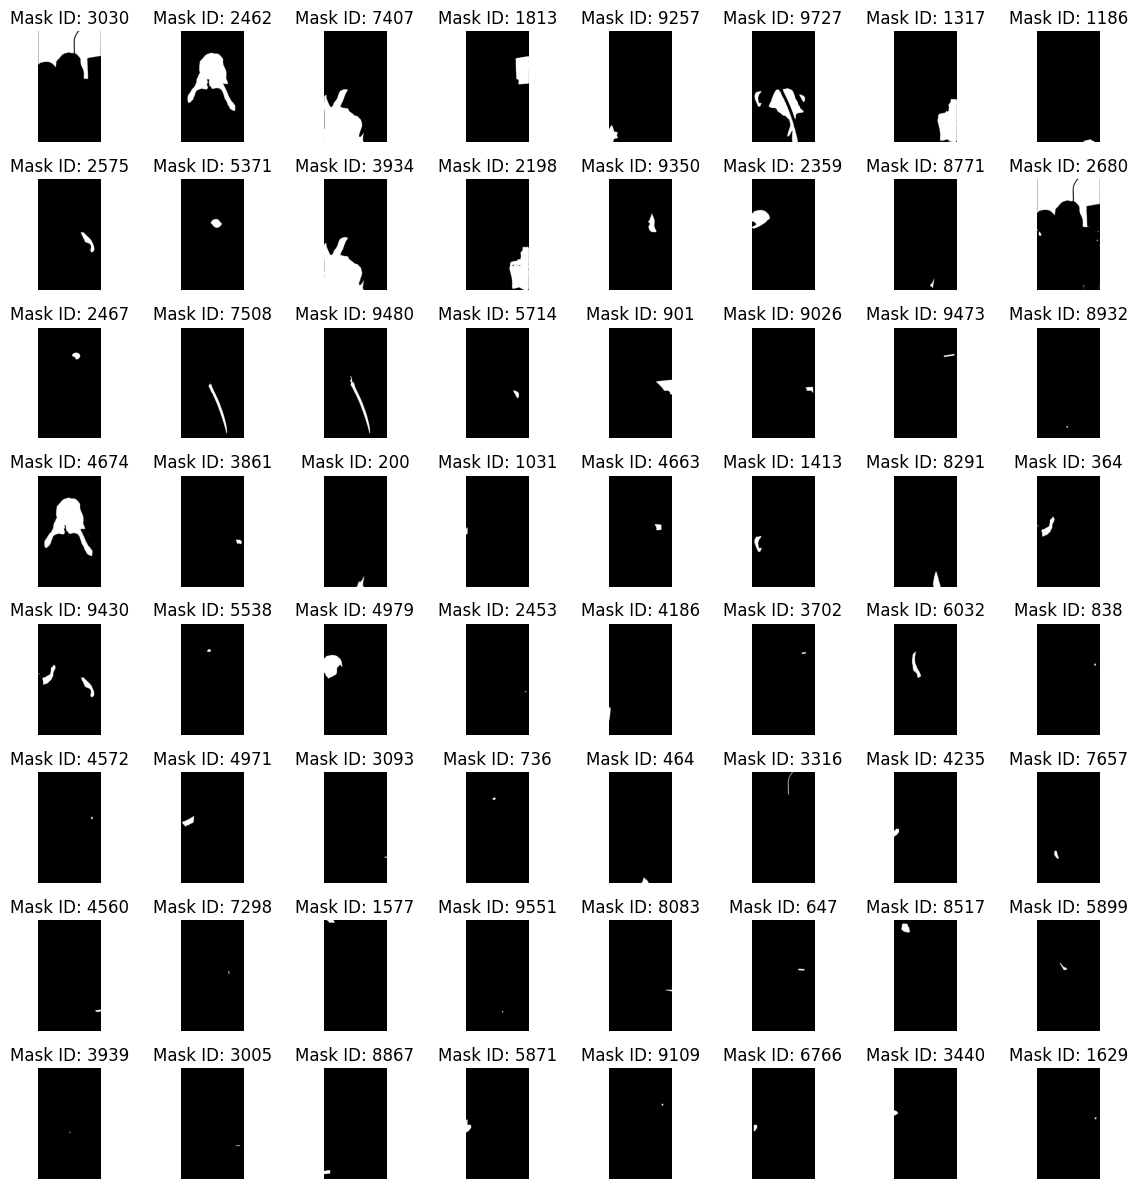

In [38]:
import random
import math
import matplotlib.pyplot as plt

# Genera gli ID casuali per le maschere
random_ids = [random.randint(0, 10000) for _ in range(len(sam_result))]

# Apre il file "encodingRLE" in modalità scrittura
with open("encodingRLE.txt", "w") as file:
    # Itera su ogni risultato di SAM
    for random_id, result in zip(random_ids, sam_result):
        # Calcola la codifica RLE per la maschera corrente
        rle_encoding = mask_to_rle(result['segmentation'])

        # Scrive l'ID della maschera e la relativa codifica RLE nel file
        file.write(f"Maschera id [{random_id}] -> RLE: {rle_encoding}\n")

# Calcola il numero di righe e colonne per la griglia
num_masks = len(sam_result)
num_cols = int(math.ceil(math.sqrt(num_masks)))  # Usa la radice quadrata arrotondata per eccesso per un layout quadrato
num_rows = (num_masks + num_cols - 1) // num_cols

# Crea una nuova figura per la griglia
plt.figure(figsize=(12, 12))

# Itera attraverso le maschere segmentate e i corrispondenti ID casuali
for idx, (result, random_id) in enumerate(zip(sam_result, random_ids)):
    # Recupera la maschera corrente
    mask = result['segmentation']

    # Aggiungi la maschera alla griglia come subplot con l'ID casuale corrispondente
    plt.subplot(num_rows, num_cols, idx+1)
    plt.imshow(mask, cmap='gray')
    plt.title(f'Mask ID: {random_id}')  # Usa l'ID casuale invece dell'indice
    plt.axis('off')

# Ottimizza il layout della griglia per evitare sovrapposizioni
plt.tight_layout()
plt.show()


In [39]:
# Ottieni le coordinate dei punti di input per la maschera con ID 1
point_coords_mask = sam_result[0]['point_coords']

for point_coord in point_coords_mask:
    print(point_coord)


[168.75, 100.0]


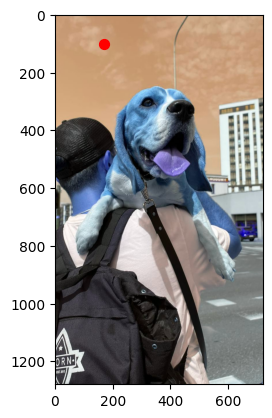

In [41]:
import matplotlib.pyplot as plt

# Coordinata x del punto
x = 168.75
# Coordinata y del punto
y = 100.0

# Visualizza l'immagine di input
plt.imshow(image_bgr)
# Traccia il punto sull'immagine
plt.scatter(x, y, color='red', s=50)  # Utilizziamo un cerchio rosso di dimensione 50 per evidenziare il punto
plt.show()

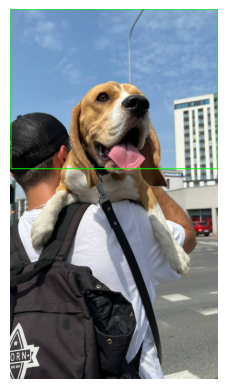

In [42]:
import cv2

# Carica l'immagine di input su cui disegnare il bbox
image_with_bbox = image_bgr.copy()

# Estrai il bbox della prima maschera
bbox = sam_result[0]['bbox']
x, y, w, h = bbox

# Disegna il rettangolo del bbox sull'immagine
cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Mostra l'immagine con il bbox
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
